In [1]:
import sympy
import symnum
import symnum.numpy as snp
import simsde
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

## Model functions

In [2]:
def drift_func_rough(x, θ):
    C, S, I = x
    α, β, σ, λ, N = θ
    return snp.array([
        α * (β - snp.log(C) + σ**2 / 2) * C
    ])  

def drift_func_smooth(x, θ):
    C, S, I = x
    α, β, σ, λ, N = θ
    return snp.array([
        -C * S * I / N,
        (C * S * I / N - λ * I),
    ])  

def diff_coeff_rough(x, θ):
    C, S, I = x
    α, β, σ, λ, N = θ
    return snp.array([[σ * C]])

def drift_func(x, θ):
    return snp.concatenate((drift_func_rough(x, θ), drift_func_smooth(x, θ)))

def diff_coeff(x, θ):
    return snp.concatenate((diff_coeff_rough(x, θ), snp.zeros((dim_x - dim_r, dim_w))), 0)

dim_x = 3
dim_r = 1
dim_w = 1
dim_θ = 5

## Simulating paths

In [3]:
use_euler_maruyama = False
if use_euler_maruyama:
    dim_n = dim_r
    step_func = simsde.integrators.euler_maruyama_step(drift_func, diff_coeff)
else:
    dim_n = 4 * dim_r - 1
    step_func = simsde.integrators.hypoelliptic_weak_order_2_step(drift_func_rough, drift_func_smooth, diff_coeff_rough)
jax_step_func = symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)

In [4]:
@jit
def simulate_diffusion(x_0, θ, t_seq, n_seq):
    
    def step_func(x, n_dt):
        n, dt = n_dt
        x_next = jax_step_func(x, θ, n, dt)
        return x_next, x_next
    
    _, x_seq = scan(step_func, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
    
    return jnp.concatenate((x_0[None], x_seq))

vmapped_simulate_diffusion = jit(vmap(simulate_diffusion, (None, None, None, 0)))

In [5]:
rng = np.random.default_rng(1234)
dt = 0.01
t_max = 20.
t_seq = np.arange(int(t_max / dt)) * dt
x_0 = np.array([1.25, 762., 1.])
θ = np.array([2.04, 0.592, 0.492, 0.505, 763.])
n_seqs = rng.standard_normal((100, t_seq.shape[0] - 1, dim_n))
x_seqs = vmapped_simulate_diffusion(x_0, θ, t_seq, n_seqs)

Text(0.5, 0, 'Time')

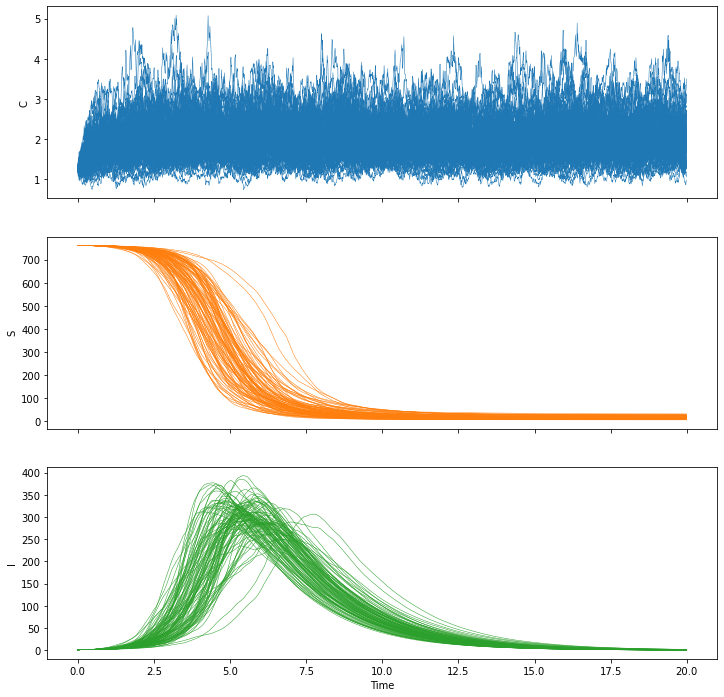

In [6]:
fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'CSI'
for i, ax in enumerate(axes):
    ax.plot(t_seq, x_seqs[:, :, i].T, color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel('Time')

## Local Gaussian approximate transition density

In [11]:
mean_and_covar_symbolic = simsde.densities.local_gaussian_mean_and_covariance(
    drift_func_rough, drift_func_smooth, diff_coeff_rough
)

In [16]:
x = snp.array(sympy.symbols('C S I'))
θ = snp.array(sympy.symbols('α β σ λ N'))
t = symnum.named_array('t', ())

In [39]:
μ, Σ = mean_and_covar_symbolic(x, θ, t)
display(μ)
display(Σ)

[C*t*α*(β + σ**2/2 - log(C)) + C, -C*I*S*t/N + S + t**2*(C**2*I**2*S/N**2 - C*I*S*α*(β + σ**2/2 - log(C))/N - C*S*(C*I*S/N - I*λ)/N)/2, I + t**2*(-C**2*I**2*S/N**2 + C*I*S*α*(β + σ**2/2 - log(C))/N + (C*S/N - λ)*(C*I*S/N - I*λ))/2 + t*(C*I*S/N - I*λ)]

[[C**2*t*σ**2, -C**2*I*S*t**2*σ**2/(2*N), C**2*I*S*t**2*σ**2/(2*N)], [-C**2*I*S*t**2*σ**2/(2*N), C**2*I**2*S**2*t**3*σ**2/(3*N**2), -C**2*I**2*S**2*t**3*σ**2/(3*N**2)], [C**2*I*S*t**2*σ**2/(2*N), -C**2*I**2*S**2*t**3*σ**2/(3*N**2), C**2*I**2*S**2*t**3*σ**2/(3*N**2)]]

In [42]:
for eigenvalue in sympy.Matrix(Σ).eigenvals():
    display(eigenvalue)

C**2*t*σ**2*(2*I**2*S**2*t**2 + 3*N**2)/(6*N**2) - C**2*t*σ**2*sqrt(4*I**4*S**4*t**4 + 6*I**2*N**2*S**2*t**2 + 9*N**4)/(6*N**2)

C**2*t*σ**2*(2*I**2*S**2*t**2 + 3*N**2)/(6*N**2) + C**2*t*σ**2*sqrt(4*I**4*S**4*t**4 + 6*I**2*N**2*S**2*t**2 + 9*N**4)/(6*N**2)

0